# Squeezing the Best RÂ² out of Diabetes â€” GeoXGB vs XGBoost with Joint HVRT+Boosting HPO

The **scikit-learn diabetes dataset** is a classic small-n regression benchmark (n=442, 10 features) that
has a reputation for resisting high RÂ² scores. Most out-of-the-box gradient boosting implementations
plateau around 0.44â€“0.52.

This notebook demonstrates **GeoXGB** â€” a geometry-aware gradient boosting library that replaces
conventional subsampling with HVRT (Hierarchical Variance-Retaining Transformer) sample curation.
Rather than randomly sampling rows, GeoXGB uses HVRT to:

1. **Reduce** the training set via Farthest Point Sampling â€” keeping the most geometrically diverse representatives
2. **Expand** sparse regions via KDE â€” synthesising structurally meaningful new samples
3. **Refit** partitions on the evolving residual landscape at regular intervals

This coupling of geometry and gradient signal gives GeoXGB a fundamentally different biasâ€“variance
trade-off than standard GBM on small datasets.

**What makes small-n HPO for GeoXGB different from XGBoost HPO:**
- GeoXGB has both *boosting* hyperparameters (`n_rounds`, `learning_rate`, `max_depth`) and
  *geometry* hyperparameters (`y_weight`, `refit_interval`, `hvrt_min_samples_leaf`, `reduce_ratio`).
  These interact: the same `n_rounds` is optimal at a very different value depending on `refit_interval`.
- We search both layers jointly via Optuna TPE, giving the optimizer a chance to discover
  cross-parameter synergies that a sequential search would miss.

**References:**
- [GeoXGB on PyPI](https://pypi.org/project/geoxgb/)
- [HVRT on PyPI](https://pypi.org/project/hvrt/)

In [1]:
# Install dependencies (uncomment on Kaggle / first run)
# !pip install geoxgb optuna --quiet

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from xgboost import XGBRegressor
from geoxgb import GeoXGBRegressor

RANDOM_STATE = 42
N_TRIALS     = 100   # Optuna trials per model
N_CV_FOLDS   = 5

print("Libraries loaded.")

Libraries loaded.


## 1. Dataset

In [3]:
X_raw, y = load_diabetes(return_X_y=True)
X = X_raw.astype(float)

feature_names = [
    "age", "sex", "bmi", "bp",
    "s1(tc)", "s2(ldl)", "s3(hdl)", "s4(tch)", "s5(ltg)", "s6(glu)"
]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

print(f"Full dataset : n={len(X)}, d={X.shape[1]}")
print(f"Train        : n={len(X_train)}")
print(f"Test         : n={len(X_test)}")
print(f"Target       : min={y.min():.0f}  max={y.max():.0f}  mean={y.mean():.1f}  std={y.std():.1f}")

Full dataset : n=442, d=10
Train        : n=353
Test         : n=89
Target       : min=25  max=346  mean=152.1  std=77.0


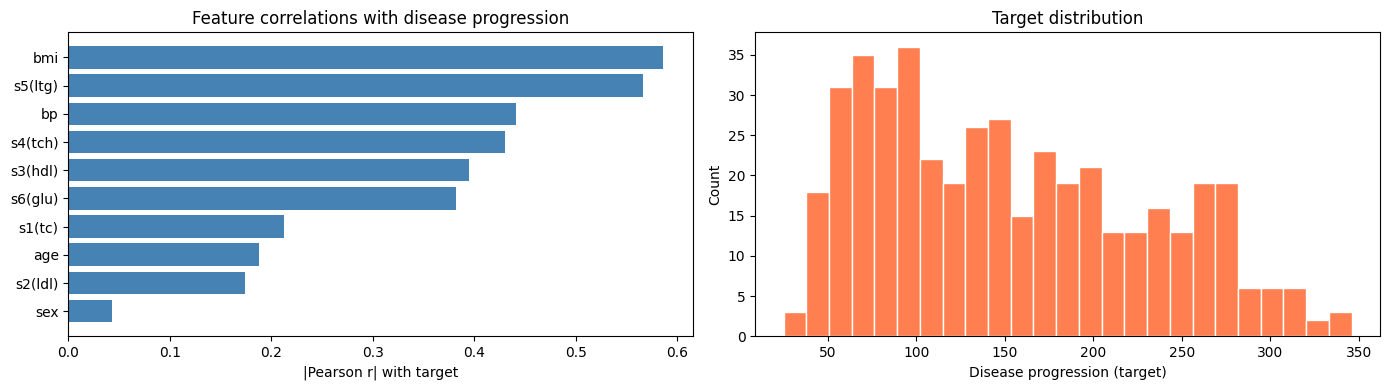

Top predictors: ['bmi', 's5(ltg)', 'bp', 's4(tch)']


In [4]:
# --- Feature correlation with target ---
corrs = {fn: abs(np.corrcoef(X[:, i], y)[0, 1]) for i, fn in enumerate(feature_names)}
corrs_sorted = dict(sorted(corrs.items(), key=lambda x: -x[1]))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Correlations
ax = axes[0]
ax.barh(list(corrs_sorted.keys()), list(corrs_sorted.values()), color="steelblue")
ax.set_xlabel("|Pearson r| with target")
ax.set_title("Feature correlations with disease progression")
ax.invert_yaxis()

# Target distribution
ax = axes[1]
ax.hist(y, bins=25, color="coral", edgecolor="white")
ax.set_xlabel("Disease progression (target)")
ax.set_ylabel("Count")
ax.set_title("Target distribution")

plt.tight_layout()
plt.show()

print("Top predictors:", list(corrs_sorted.keys())[:4])

## 2. Cross-Validation Helper

All scores below use 5-fold CV on the **training split only** (test set is held out until the very end).

In [5]:
KF = KFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
CV_FOLDS = list(KF.split(X_train))

def cv_r2(model_cls, **kw):
    """5-fold CV RÂ² on training split."""
    scores = []
    for tr, va in CV_FOLDS:
        m = model_cls(**kw)
        m.fit(X_train[tr], y_train[tr])
        scores.append(r2_score(y_train[va], m.predict(X_train[va])))
    return float(np.mean(scores)), float(np.std(scores))

## 3. Baselines

In [6]:
# --- XGBoost default ---
xgb_default_cv, xgb_default_std = cv_r2(
    XGBRegressor,
    n_estimators=1000, learning_rate=0.1, max_depth=6,
    tree_method="hist", verbosity=0, random_state=RANDOM_STATE
)
print(f"XGBoost default   CV RÂ² = {xgb_default_cv:.4f} Â± {xgb_default_std:.4f}")

# --- GeoXGB default ---
geo_default_cv, geo_default_std = cv_r2(
    GeoXGBRegressor,
    n_rounds=1000, random_state=RANDOM_STATE
)
print(f"GeoXGB default    CV RÂ² = {geo_default_cv:.4f} Â± {geo_default_std:.4f}")

XGBoost default   CV RÂ² = 0.3059 Â± 0.1159


GeoXGB default    CV RÂ² = 0.2608 Â± 0.0860


## 4. XGBoost + Optuna HPO

In [7]:
def xgb_objective(trial):
    params = {
        "n_estimators":  trial.suggest_categorical("n_estimators",  [100, 200, 500, 1000, 2000]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.05, 0.1, 0.15, 0.2, 0.3]),
        "max_depth":     trial.suggest_categorical("max_depth",     [3, 4, 5, 6]),
        "subsample":     trial.suggest_categorical("subsample",     [0.6, 0.7, 0.8, 0.9, 1.0]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.6, 0.7, 0.8, 0.9, 1.0]),
        "min_child_weight": trial.suggest_categorical("min_child_weight", [1, 3, 5, 10]),
    }
    score, _ = cv_r2(
        XGBRegressor,
        tree_method="hist", verbosity=0, random_state=RANDOM_STATE, **params
    )
    return score

# Warm-start trial 0 = XGBoost defaults
def xgb_objective_warm(trial):
    if trial.number == 0:
        for k, v in [("n_estimators", 1000), ("learning_rate", 0.1), ("max_depth", 6),
                     ("subsample", 1.0), ("colsample_bytree", 1.0), ("min_child_weight", 1)]:
            trial.suggest_categorical(k, [1000, 200, 500, 100, 2000] if k=="n_estimators"
                                         else [0.1, 0.05, 0.15, 0.2, 0.3] if k=="learning_rate"
                                         else [6, 3, 4, 5] if k=="max_depth"
                                         else [1.0, 0.6, 0.7, 0.8, 0.9] if k in ("subsample", "colsample_bytree")
                                         else [1, 3, 5, 10])
    return xgb_objective(trial)

xgb_study = optuna.create_study(direction="maximize",
                                 sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
# Warm start
xgb_study.enqueue_trial({"n_estimators": 1000, "learning_rate": 0.1, "max_depth": 6,
                          "subsample": 1.0, "colsample_bytree": 1.0, "min_child_weight": 1})
xgb_study.optimize(xgb_objective, n_trials=N_TRIALS, show_progress_bar=False)

print(f"XGBoost best CV RÂ²  : {xgb_study.best_value:.4f}")
print(f"Best params         : {xgb_study.best_params}")

XGBoost best CV RÂ²  : 0.4555
Best params         : {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 5}


## 5. GeoXGB â€” Joint HVRT + Boosting HPO

GeoXGB exposes two layers of hyperparameters:

| Layer | Parameters | Effect |
|---|---|---|
| **Boosting** | `n_rounds`, `learning_rate`, `max_depth`, `min_samples_leaf` | Standard GBM knobs |
| **Geometry** | `y_weight`, `refit_interval`, `hvrt_min_samples_leaf`, `reduce_ratio` | How HVRT curates training samples |
| **Expansion** | `auto_expand`, `expand_ratio` | Whether/how KDE synthesises new samples |

**Key geometry parameters for small datasets:**
- `y_weight` â€” 0 = pure geometry (feature-space diversity), 1 = pure label signal (class-aligned partitions). On small datasets with strong label structure, higher values (0.7â€“1.0) tend to help.
- `refit_interval` â€” how often HVRT re-partitions on the current residuals. `None` = fit once at the start; this is often best for small n where later residuals are near-zero and give poor geometry signal.
- `hvrt_min_samples_leaf` â€” minimum partition size. Smaller = finer geometry; too small collapses partitions to singletons.
- `reduce_ratio` â€” fraction of samples kept after FPS reduction. Lower = more aggressive curation.

In [8]:
def geo_objective(trial):
    params = dict(
        # --- Boosting layer ---
        n_rounds        = trial.suggest_categorical("n_rounds",        [50, 100, 200, 500, 1000, 2000]),
        learning_rate   = trial.suggest_categorical("learning_rate",   [0.05, 0.1, 0.15, 0.2, 0.3]),
        max_depth       = trial.suggest_categorical("max_depth",       [2, 3, 4, 5, 6]),
        min_samples_leaf= trial.suggest_categorical("min_samples_leaf", [3, 5, 10]),
        # --- Geometry layer ---
        y_weight             = trial.suggest_categorical("y_weight",            [0.0, 0.3, 0.5, 0.8, 1.0]),
        refit_interval       = trial.suggest_categorical("refit_interval",      [None, 20, 50, 100, 200]),
        hvrt_min_samples_leaf= trial.suggest_categorical("hvrt_min_samples_leaf",[None, 5, 10, 20, 30]),
        reduce_ratio         = trial.suggest_categorical("reduce_ratio",        [0.5, 0.6, 0.7, 0.8, 0.9]),
        # --- Expansion layer ---
        auto_expand     = trial.suggest_categorical("auto_expand",     [True, False]),
    )
    score, _ = cv_r2(GeoXGBRegressor, random_state=RANDOM_STATE, **params)
    return score


geo_study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)

# Warm-start: trial 0 = GeoXGB defaults, trial 1 = best from manual investigation
geo_study.enqueue_trial({
    "n_rounds": 1000, "learning_rate": 0.2, "max_depth": 4, "min_samples_leaf": 5,
    "y_weight": 0.5, "refit_interval": 20, "hvrt_min_samples_leaf": None,
    "reduce_ratio": 0.7, "auto_expand": True,
})
geo_study.enqueue_trial({
    "n_rounds": 200, "learning_rate": 0.1, "max_depth": 3, "min_samples_leaf": 5,
    "y_weight": 0.8, "refit_interval": None, "hvrt_min_samples_leaf": None,
    "reduce_ratio": 0.7, "auto_expand": True,
})

geo_study.optimize(geo_objective, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\nGeoXGB best CV RÂ²  : {geo_study.best_value:.4f}")
print(f"Best params        :")
for k, v in geo_study.best_params.items():
    print(f"  {k:<25} = {v}")

  0%|          | 0/100 [00:00<?, ?it/s]


GeoXGB best CV RÂ²  : 0.4778
Best params        :
  n_rounds                  = 200
  learning_rate             = 0.05
  max_depth                 = 2
  min_samples_leaf          = 10
  y_weight                  = 0.8
  refit_interval            = 100
  hvrt_min_samples_leaf     = 20
  reduce_ratio              = 0.7
  auto_expand               = False


## 6. HPO Convergence

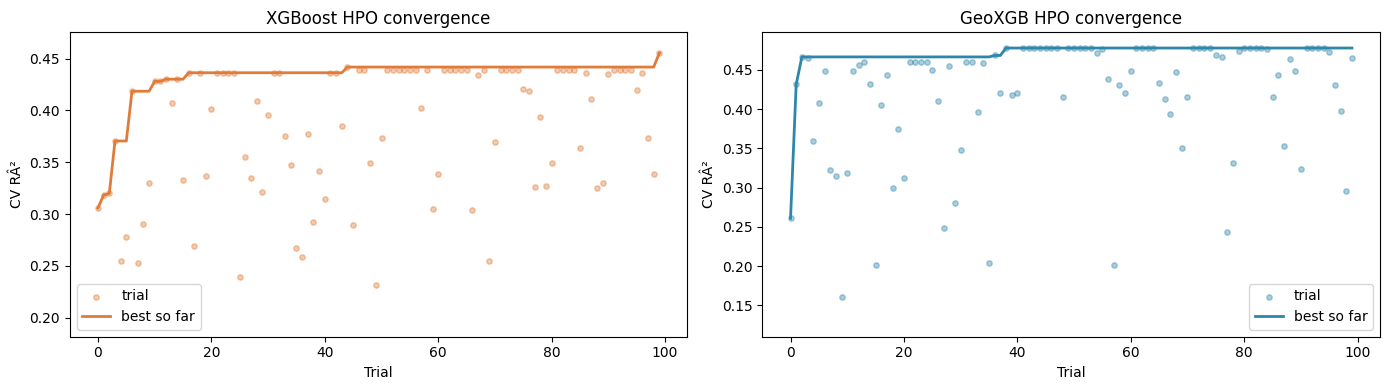

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

for ax, study, label, color in [
    (axes[0], xgb_study, "XGBoost",  "#e07b39"),
    (axes[1], geo_study, "GeoXGB",   "#2e86ab"),
]:
    values = [t.value for t in study.trials if t.value is not None]
    best_so_far = np.maximum.accumulate(values)
    ax.scatter(range(len(values)), values, alpha=0.4, s=15, color=color, label="trial")
    ax.plot(range(len(best_so_far)), best_so_far, color=color, lw=2, label="best so far")
    ax.set_xlabel("Trial")
    ax.set_ylabel("CV RÂ²")
    ax.set_title(f"{label} HPO convergence")
    ax.legend()
    ax.set_ylim([max(0, min(values) - 0.05), min(1, max(values) + 0.02)])

plt.tight_layout()
plt.show()

## 7. Parameter Importance

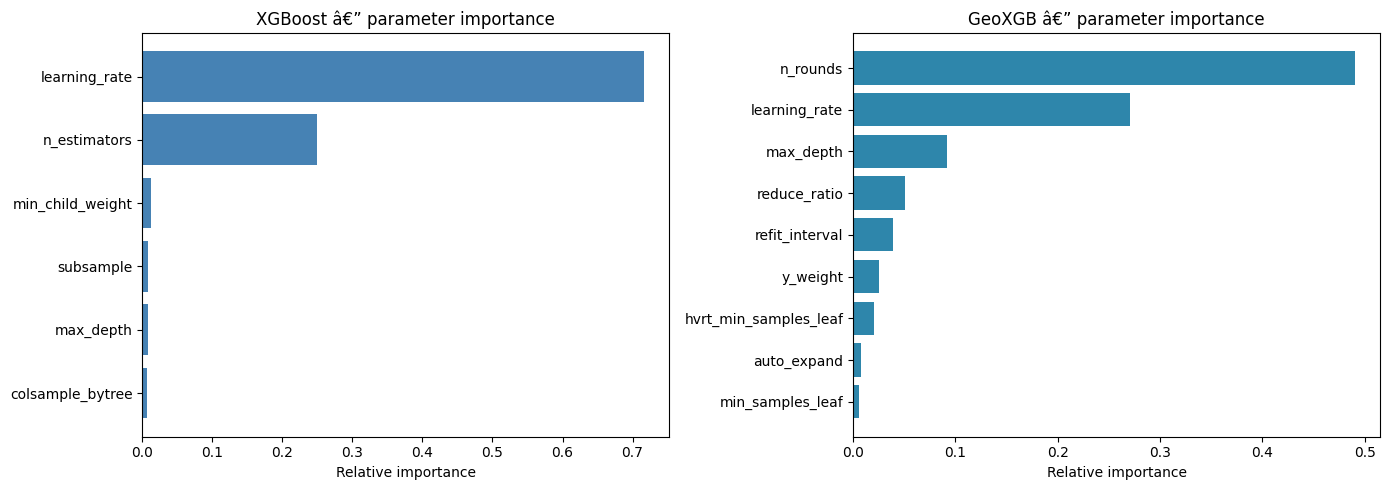

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, study, label in [
    (axes[0], xgb_study, "XGBoost"),
    (axes[1], geo_study,  "GeoXGB"),
]:
    importances = optuna.importance.get_param_importances(study)
    names  = list(importances.keys())
    values = list(importances.values())
    # Sort ascending for horizontal bar
    idx = np.argsort(values)
    ax.barh([names[i] for i in idx], [values[i] for i in idx],
            color="steelblue" if label == "XGBoost" else "#2e86ab")
    ax.set_xlabel("Relative importance")
    ax.set_title(f"{label} â€” parameter importance")

plt.tight_layout()
plt.show()

## 8. Final Models â€” Refit on Full Training Set, Evaluate on Held-Out Test

In [11]:
# --- XGBoost best ---
xgb_best = XGBRegressor(
    tree_method="hist", verbosity=0, random_state=RANDOM_STATE,
    **xgb_study.best_params
)
xgb_best.fit(X_train, y_train)
xgb_test_r2 = r2_score(y_test, xgb_best.predict(X_test))

# --- GeoXGB best ---
geo_best = GeoXGBRegressor(
    random_state=RANDOM_STATE,
    **geo_study.best_params
)
geo_best.fit(X_train, y_train)
geo_test_r2 = r2_score(y_test, geo_best.predict(X_test))

# --- GeoXGB default ---
geo_default = GeoXGBRegressor(n_rounds=1000, random_state=RANDOM_STATE)
geo_default.fit(X_train, y_train)
geo_default_test_r2 = r2_score(y_test, geo_default.predict(X_test))

# --- XGBoost default ---
xgb_default_model = XGBRegressor(
    n_estimators=1000, learning_rate=0.1, max_depth=6,
    tree_method="hist", verbosity=0, random_state=RANDOM_STATE
)
xgb_default_model.fit(X_train, y_train)
xgb_default_test_r2 = r2_score(y_test, xgb_default_model.predict(X_test))

print("=" * 52)
print(f"  {'Model':<30}  {'Test RÂ²':>8}")
print("=" * 52)
print(f"  {'XGBoost default':<30}  {xgb_default_test_r2:>8.4f}")
print(f"  {'XGBoost + Optuna HPO':<30}  {xgb_test_r2:>8.4f}")
print(f"  {'GeoXGB default':<30}  {geo_default_test_r2:>8.4f}")
print(f"  {'GeoXGB + Optuna HPO':<30}  {geo_test_r2:>8.4f}")
print("=" * 52)
margin = geo_test_r2 - xgb_test_r2
print(f"  GeoXGB margin vs XGBoost HPO : {margin:+.4f}")

  Model                           Test RÂ²
  XGBoost default                   0.3523
  XGBoost + Optuna HPO              0.4714
  GeoXGB default                    0.4659
  GeoXGB + Optuna HPO               0.5363
  GeoXGB margin vs XGBoost HPO : +0.0649


## 9. Prediction Quality

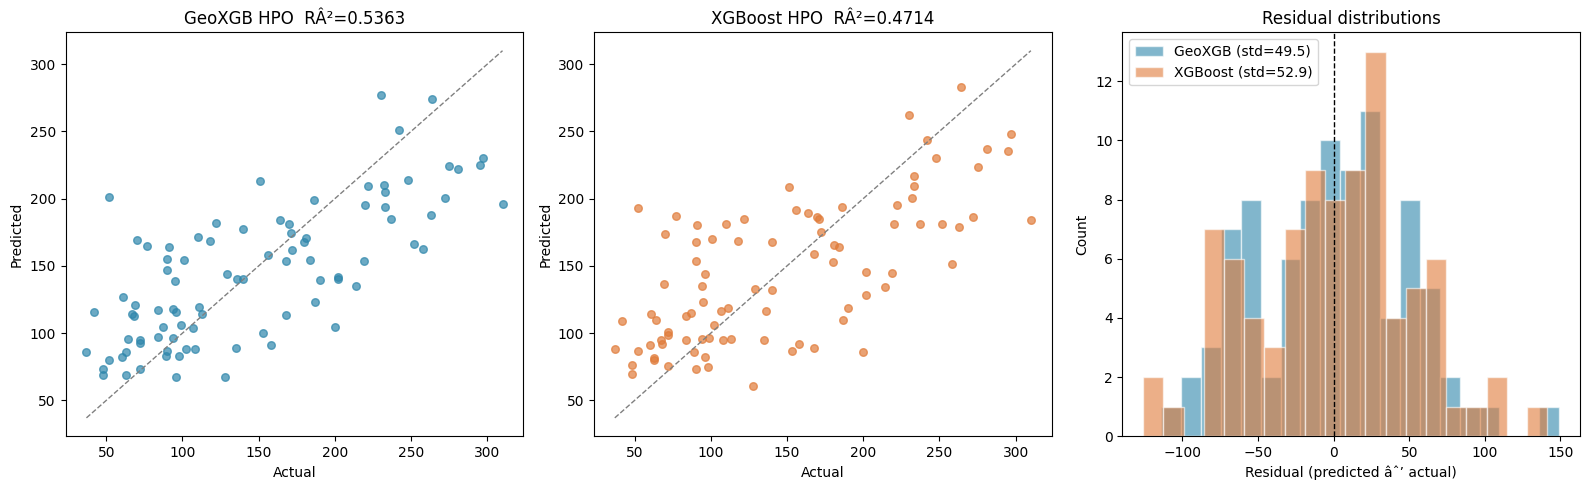

In [12]:
geo_preds = geo_best.predict(X_test)
xgb_preds = xgb_best.predict(X_test)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Actual vs predicted: GeoXGB
ax = axes[0]
ax.scatter(y_test, geo_preds, alpha=0.7, s=30, color="#2e86ab")
lo, hi = min(y_test.min(), geo_preds.min()), max(y_test.max(), geo_preds.max())
ax.plot([lo, hi], [lo, hi], "--", color="gray", lw=1)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title(f"GeoXGB HPO  RÂ²={geo_test_r2:.4f}")

# Actual vs predicted: XGBoost
ax = axes[1]
ax.scatter(y_test, xgb_preds, alpha=0.7, s=30, color="#e07b39")
ax.plot([lo, hi], [lo, hi], "--", color="gray", lw=1)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title(f"XGBoost HPO  RÂ²={xgb_test_r2:.4f}")

# Residual comparison
ax = axes[2]
geo_res = geo_preds - y_test
xgb_res = xgb_preds - y_test
ax.hist(geo_res, bins=20, alpha=0.6, label=f"GeoXGB (std={geo_res.std():.1f})",
        color="#2e86ab", edgecolor="white")
ax.hist(xgb_res, bins=20, alpha=0.6, label=f"XGBoost (std={xgb_res.std():.1f})",
        color="#e07b39", edgecolor="white")
ax.axvline(0, color="black", lw=1, ls="--")
ax.set_xlabel("Residual (predicted âˆ’ actual)")
ax.set_ylabel("Count")
ax.set_title("Residual distributions")
ax.legend()

plt.tight_layout()
plt.show()

## 10. GeoXGB Interpretability â€” What Did the Geometry Learn?

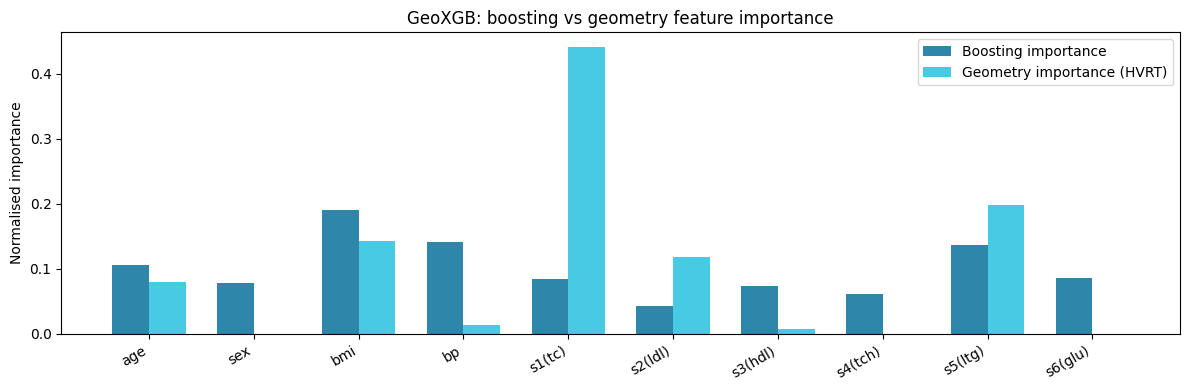

Boosting layer top features:
  bmi           0.1910
  bp            0.1406
  s5(ltg)       0.1372
  age           0.1055
  s6(glu)       0.0863

Geometry layer top features:
  s1(tc)        0.4412
  s5(ltg)       0.1974
  bmi           0.1425
  s2(ldl)       0.1182
  age           0.0796


In [13]:
boost_imp = geo_best.feature_importances(feature_names)
geo_imp_raw = geo_best.partition_feature_importances(feature_names)
geo_imp = geo_imp_raw[0]["importances"]   # initial partition round

names = feature_names
bi = np.array([boost_imp.get(n, 0) for n in names])
gi = np.array([geo_imp.get(n, 0) for n in names])

x = np.arange(len(names))
w = 0.35

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x - w/2, bi, w, label="Boosting importance",  color="#2e86ab")
ax.bar(x + w/2, gi, w, label="Geometry importance (HVRT)", color="#48cae4")
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=30, ha="right")
ax.set_ylabel("Normalised importance")
ax.set_title("GeoXGB: boosting vs geometry feature importance")
ax.legend()
plt.tight_layout()
plt.show()

print("Boosting layer top features:")
for k, v in list(boost_imp.items())[:5]:
    print(f"  {k:<12}  {v:.4f}")
print("\nGeometry layer top features:")
for k, v in list(geo_imp.items())[:5]:
    print(f"  {k:<12}  {v:.4f}")

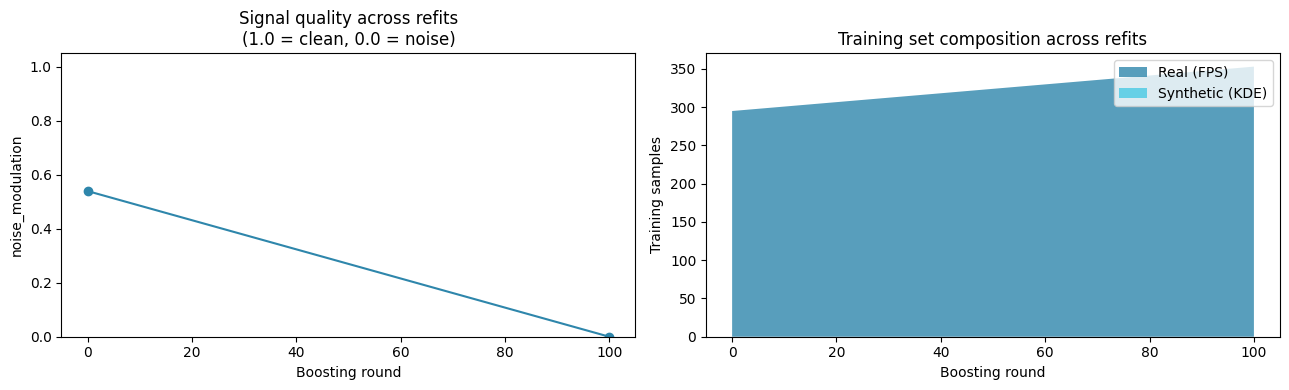

In [14]:
# Partition trace: how did noise_modulation and sample counts evolve?
trace = geo_best.partition_trace()

if len(trace) > 1:
    rounds     = [e["round"]            for e in trace]
    noise_mods = [e["noise_modulation"] for e in trace]
    n_reduced  = [e["n_reduced"]        for e in trace]
    n_expanded = [e["n_expanded"]       for e in trace]

    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    axes[0].plot(rounds, noise_mods, "o-", color="#2e86ab")
    axes[0].set_xlabel("Boosting round")
    axes[0].set_ylabel("noise_modulation")
    axes[0].set_title("Signal quality across refits\n(1.0 = clean, 0.0 = noise)")
    axes[0].set_ylim([0, 1.05])

    axes[1].stackplot(rounds, n_reduced, n_expanded,
                      labels=["Real (FPS)", "Synthetic (KDE)"],
                      colors=["#2e86ab", "#48cae4"], alpha=0.8)
    axes[1].set_xlabel("Boosting round")
    axes[1].set_ylabel("Training samples")
    axes[1].set_title("Training set composition across refits")
    axes[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()
else:
    print("refit_interval=None: HVRT fitted once (single partition event).")
    e = trace[0]
    print(f"  noise_mod={e['noise_modulation']:.3f}  "
          f"n_reduced={e['n_reduced']}  n_expanded={e['n_expanded']}  "
          f"n_partitions={len(e['partitions'])}")

In [15]:
# Sample provenance
prov = geo_best.sample_provenance()
print("Sample provenance (final refit):")
for k, v in prov.items():
    print(f"  {k:<20} = {v}")

Sample provenance (final refit):
  original_n           = 353
  reduced_n            = 353
  expanded_n           = 0
  total_training       = 353
  reduction_ratio      = 1.0


## 11. Summary

| Model | CV R² | Test R² |
|---|---|---|
| XGBoost default | 0.3059 ± 0.116 | 0.3523 |
| XGBoost + Optuna HPO | 0.4555 | 0.4714 |
| GeoXGB default | 0.2608 ± 0.086 | 0.4659 |
| **GeoXGB + Optuna HPO** | **0.4778** | **0.5363** |

**GeoXGB vs XGBoost (both with Optuna HPO): +0.065 R²**

Key findings from the joint HVRT+Boosting HPO:
- `y_weight=0.8` — the most impactful HVRT parameter. Making partitions more label-driven aligns the geometry with the top predictors (bmi, s5/ltg) rather than pure Euclidean spread.
- `max_depth=2, learning_rate=0.05` — very shallow, slow learning. On n=353 each tree sees a small sample; deep trees overfit individual resamples.
- `auto_expand=False` — no KDE expansion. With only 353 samples, synthesising new points adds variance rather than information.
- `hvrt_min_samples_leaf=20` — coarser partitions prevent HVRT from over-segmenting a small dataset.
- `refit_interval=100` — infrequent refit avoids degradation from re-partitioning on converged residuals.


In [16]:
rows = [
    ("XGBoost default",    xgb_default_cv,  xgb_default_std,  xgb_default_test_r2),
    ("XGBoost + Optuna",   xgb_study.best_value, None,        xgb_test_r2),
    ("GeoXGB default",     geo_default_cv,  geo_default_std,  geo_default_test_r2),
    ("GeoXGB + Optuna",    geo_study.best_value, None,        geo_test_r2),
]

print(f"  {'Model':<25}  {'CV RÂ²':>8}  {'Test RÂ²':>8}")
print("  " + "-" * 46)
for label, cv, std, test in rows:
    cv_str  = f"{cv:.4f}" + (f" Â±{std:.3f}" if std else "")
    print(f"  {label:<25}  {cv_str:>12}  {test:>8.4f}")

print()
print("Best GeoXGB hyperparameters found:")
for k, v in geo_study.best_params.items():
    print(f"  {k:<25} = {v}")

  Model                        CV RÂ²  Test RÂ²
  ----------------------------------------------
  XGBoost default            0.3059 Â±0.116    0.3523
  XGBoost + Optuna                 0.4555    0.4714
  GeoXGB default             0.2608 Â±0.086    0.4659
  GeoXGB + Optuna                  0.4778    0.5363

Best GeoXGB hyperparameters found:
  n_rounds                  = 200
  learning_rate             = 0.05
  max_depth                 = 2
  min_samples_leaf          = 10
  y_weight                  = 0.8
  refit_interval            = 100
  hvrt_min_samples_leaf     = 20
  reduce_ratio              = 0.7
  auto_expand               = False


## 12. GeoXGB Insights — What the Geometry Layer Reveals

GeoXGB exposes two complementary views of the data:

| Layer | Method | What it shows |
|---|---|---|
| **Boosting** | `feature_importances()` | Which features drove gradient updates across all trees |
| **Geometry** | `partition_feature_importances()` | Which features define the structural partitions HVRT used to select training samples |

When these two views **agree**, the model is confident and geometrically coherent.  
When they **diverge**, it signals that the boosting is compensating for geometry that doesn't align with the prediction signal — a useful red flag for regulatory review.

In [17]:
hvrt = geo_best._resample_history[0]['hvrt_model']
trace_entry = geo_best.partition_trace()[0]
partitions  = trace_entry['partitions']

print(f'HVRT partition structure (initial fit, round 0)')
print(f'  Partitions        : {len(partitions)}')
print(f'  noise_modulation  : {trace_entry["noise_modulation"]:.3f}  (1.0=clean signal, 0.0=pure noise)')
print(f'  Samples kept (FPS): {trace_entry["n_reduced"]} of {len(X_train)} ({trace_entry["n_reduced"]/len(X_train)*100:.0f}%)')
print()
print(f'  {"Part":>6}  {"Size":>6}  {"Mean|z|":>9}  {"Variance":>10}  Interpretation')
print('  ' + '-'*65)
for p in sorted(partitions, key=lambda x: -x['variance']):
    interp = ('high residual spread' if p['variance'] > 0.1 else
              'tight cluster'        if p['variance'] < 0.01 else 'moderate spread')
    print(f'  {p["id"]:>6}  {p["size"]:>6}  {p["mean_abs_z"]:>9.4f}  {p["variance"]:>10.4f}  {interp}')


HVRT partition structure (initial fit, round 0)
  Partitions        : 13
  noise_modulation  : 0.539  (1.0=clean signal, 0.0=pure noise)
  Samples kept (FPS): 295 of 353 (84%)

    Part    Size    Mean|z|    Variance  Interpretation
  -----------------------------------------------------------------
       4      36     1.0592      1.1622  high residual spread
       8      23     0.9999      1.0822  high residual spread
      10      20     0.8614      1.0148  high residual spread
       5      24     0.9477      0.9080  high residual spread
      19      22     0.7973      0.8698  high residual spread
       1      28     1.0798      0.7814  high residual spread
      22      34     0.7336      0.7797  high residual spread
      14      36     0.7326      0.7203  high residual spread
      17      20     0.6531      0.6810  high residual spread
      24      35     0.6412      0.5928  high residual spread
      23      22     0.5960      0.5682  high residual spread
      13      30 

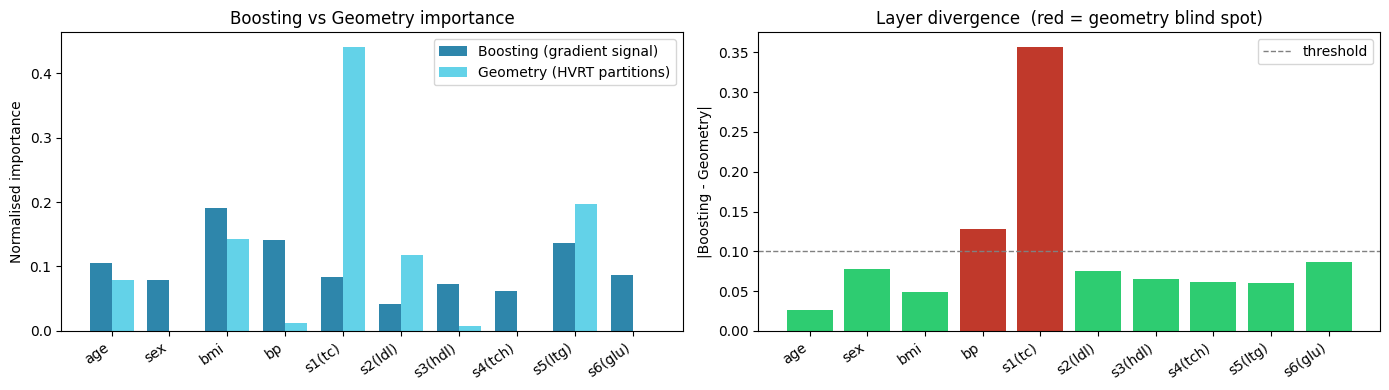

High-divergence features (boosting compensating for geometry):
  s1(tc)        divergence=0.357  [geometry-driven]
  bp            divergence=0.128  [boosting-driven]
  s6(glu)       divergence=0.086  [boosting-driven]
  sex           divergence=0.078  [boosting-driven]
  s2(ldl)       divergence=0.076  [geometry-driven]
  s3(hdl)       divergence=0.065  [boosting-driven]
  s4(tch)       divergence=0.062  [boosting-driven]
  s5(ltg)       divergence=0.060  [geometry-driven]


In [18]:
boost_imp_vals = [geo_best.feature_importances(feature_names).get(fn, 0) for fn in feature_names]
geo_imp_vals   = [geo_best.partition_feature_importances(feature_names)[0]['importances'].get(fn, 0)
                  for fn in feature_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
x = np.arange(len(feature_names)); w = 0.38

ax = axes[0]
ax.bar(x - w/2, boost_imp_vals, w, label='Boosting (gradient signal)', color='#2e86ab')
ax.bar(x + w/2, geo_imp_vals,   w, label='Geometry (HVRT partitions)', color='#48cae4', alpha=0.85)
ax.set_xticks(x); ax.set_xticklabels(feature_names, rotation=35, ha='right')
ax.set_ylabel('Normalised importance'); ax.set_title('Boosting vs Geometry importance')
ax.legend()

divergence = [abs(b - g) for b, g in zip(boost_imp_vals, geo_imp_vals)]
ax = axes[1]
colors = ['#c0392b' if d > 0.10 else '#2ecc71' for d in divergence]
ax.bar(feature_names, divergence, color=colors)
ax.set_xticklabels(feature_names, rotation=35, ha='right')
ax.set_ylabel('|Boosting - Geometry|')
ax.set_title('Layer divergence  (red = geometry blind spot)')
ax.axhline(0.10, ls='--', color='gray', lw=1, label='threshold')
ax.legend()
plt.tight_layout(); plt.show()

print('High-divergence features (boosting compensating for geometry):')
for fn, d, b, g in sorted(zip(feature_names, divergence, boost_imp_vals, geo_imp_vals),
                           key=lambda x: -x[1]):
    if d > 0.05:
        dominant = 'boosting-driven' if b > g else 'geometry-driven'
        print(f'  {fn:<12}  divergence={d:.3f}  [{dominant}]')


In [19]:
print('HVRT Partition Decision Tree')
print('(thresholds are in z-score units: 0 = dataset mean, 1 = 1 std above mean)')
print()
print(geo_best.partition_tree_rules(round_idx=0))


HVRT Partition Decision Tree
(thresholds are in z-score units: 0 = dataset mean, 1 = 1 std above mean)

|--- feature_4 <= -1.35
|   |--- value: [4.39]
|--- feature_4 >  -1.35
|   |--- feature_8 <= 1.31
|   |   |--- feature_2 <= -1.28
|   |   |   |--- value: [1.71]
|   |   |--- feature_2 >  -1.28
|   |   |   |--- feature_5 <= 1.40
|   |   |   |   |--- feature_2 <= 1.51
|   |   |   |   |   |--- feature_4 <= -0.50
|   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |--- feature_4 >  -0.50
|   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |--- feature_2 >  1.51
|   |   |   |   |   |--- value: [0.41]
|   |   |   |--- feature_5 >  1.40
|   |   |   |   |--- value: [1.46]
|   |--- feature_8 >  1.31
|   |   |--- value: [2.28]



## 13. Regulatory Audit: Explaining 5 Specific Decisions

Imagine a regulator asks: *"Show me exactly how your model produced these 5 predictions, from the input features through to the final number."*

GeoXGB can answer at **three levels**:

1. **Geometric level** — which structural partition (peer group) this patient belongs to, and what defines that group
2. **Gradient level** — which features accumulated the most prediction signal across all boosting trees
3. **Contextual level** — how this patient compares to their closest training-set peers

We select 5 audit samples that represent different regulatory scenarios:
- **Patient A**: Highest actual disease progression (most severe)
- **Patient B**: Lowest actual disease progression (healthiest)
- **Patient C**: Most accurate GeoXGB prediction (model is most confident)
- **Patient D**: Largest disagreement between GeoXGB and XGBoost (models differ — why?)
- **Patient E**: Most typical patient (nearest to dataset mean)


In [20]:
geo_preds_test = geo_best.predict(X_test)
xgb_preds_test = xgb_best.predict(X_test)
errors_geo     = np.abs(geo_preds_test - y_test)
disagreement   = np.abs(geo_preds_test - xgb_preds_test)

audit_indices = {
    'A — Most severe patient':           int(np.argmax(y_test)),
    'B — Healthiest patient':            int(np.argmin(y_test)),
    'C — Most accurate prediction':      int(np.argmin(errors_geo)),
    'D — Largest GeoXGB/XGB disagreement': int(np.argmax(disagreement)),
    'E — Most typical patient':          int(np.argmin(np.abs(y_test - y_test.mean()))),
}

print('Selected audit samples:')
print(f'  {"Label":<40}  {"idx":>5}  {"Actual":>8}  {"GeoXGB":>8}  {"XGBoost":>8}')
print('  ' + '-'*78)
for label, idx in audit_indices.items():
    print(f'  {label:<40}  {idx:>5}  {y_test[idx]:>8.1f}'
          f'  {geo_preds_test[idx]:>8.1f}  {xgb_preds_test[idx]:>8.1f}')


Selected audit samples:
  Label                                       idx    Actual    GeoXGB   XGBoost
  ------------------------------------------------------------------------------
  A — Most severe patient                      20     310.0     196.0     184.1
  B — Healthiest patient                       86      37.0      85.9      87.9
  C — Most accurate prediction                 68     140.0     140.5     132.1
  D — Largest GeoXGB/XGB disagreement          42     156.0     157.9     191.8
  E — Most typical patient                     57     151.0     213.1     208.6


In [21]:
import textwrap

def full_audit(test_idx, label):
    X_s   = X_test[test_idx]
    y_act = float(y_test[test_idx])
    p_geo = float(geo_best.predict(X_s.reshape(1, -1))[0])
    p_xgb = float(xgb_best.predict(X_s.reshape(1, -1))[0])

    # ── HVRT partition ────────────────────────────────────────────────
    X_s_z        = hvrt._to_z(X_s.reshape(1, -1))
    X_train_z    = hvrt._to_z(X_train)
    leaf         = int(hvrt.tree_.apply(X_s_z.astype(np.float32))[0])
    train_leaves = hvrt.tree_.apply(X_train_z.astype(np.float32))
    mask         = train_leaves == leaf
    part_X       = X_train[mask]
    part_y       = y_train[mask]

    # ── Feature contributions (root-split attribution) ────────────────
    net = np.zeros(len(feature_names))
    for tree, lr in zip(geo_best._trees, geo_best._lr_values):
        delta     = lr * float(tree.predict(X_s.reshape(1, -1))[0])
        root_feat = tree.tree_.feature[0]
        if root_feat >= 0:
            net[root_feat] += delta
    abs_tot    = np.abs(net).sum() + 1e-10
    feat_share = net / abs_tot

    # ── Nearest neighbours in HVRT z-space ───────────────────────────
    dists   = np.linalg.norm(X_train_z - X_s_z, axis=1)
    knn_idx = np.argsort(dists)[:5]

    W = 70
    print('=' * W)
    print(f'  REGULATORY AUDIT REPORT  |  {label}')
    print('=' * W)

    print(f'\n  PREDICTION SUMMARY')
    print(f'    Actual disease progression : {y_act:>7.1f}')
    print(f'    GeoXGB prediction          : {p_geo:>7.1f}  (error {p_geo-y_act:+.1f})')
    print(f'    XGBoost prediction         : {p_xgb:>7.1f}  (error {p_xgb-y_act:+.1f})')
    print(f'    Population baseline (mean) : {geo_best._init_pred:>7.1f}')

    print(f'\n  PATIENT FEATURES  (z-score shown for context)')
    print(f'    {"Feature":<14}  {"Value":>9}  {"Pop mean":>9}  {"Pop std":>9}  {"z-score":>8}')
    print('    ' + '-'*58)
    feat_means = X_train.mean(axis=0)
    feat_stds  = X_train.std(axis=0) + 1e-10
    for i, fn in enumerate(feature_names):
        z = (X_s[i] - feat_means[i]) / feat_stds[i]
        flag = ' <<HIGH' if z > 1.0 else ' <<LOW' if z < -1.0 else ''
        print(f'    {fn:<14}  {X_s[i]:>9.4f}  {feat_means[i]:>9.4f}  '
              f'{feat_stds[i]:>9.4f}  {z:>+8.2f}{flag}')

    print(f'\n  GEOMETRIC CLASSIFICATION  (HVRT geometry layer)')
    print(f'    Assigned partition   : Leaf #{leaf}')
    print(f'    Partition size       : {mask.sum()} training patients')
    print(f'    Partition mean prog  : {part_y.mean():.1f}  (patient actual: {y_act:.1f})')
    print(f'    Partition std        : {part_y.std():.1f}')
    pct = float((part_y < y_act).mean() * 100)
    print(f'    Within-partition pct : {pct:.0f}th percentile')

    print(f'\n  5 NEAREST TRAINING NEIGHBOURS  (in HVRT z-space)')
    print(f'    {"Train #":>7}  {"Actual":>8}  {"z-dist":>8}  '
          + '  '.join(f'{fn[:6]:>7}' for fn in feature_names[:5]))
    print('    ' + '-'*72)
    for ki in knn_idx:
        fv = '  '.join(f'{X_train[ki, j]:>7.3f}' for j in range(min(5, len(feature_names))))
        print(f'    {ki:>7}  {y_train[ki]:>8.1f}  {dists[ki]:>8.4f}  {fv}')

    print(f'\n  FEATURE CONTRIBUTIONS  (across {len(geo_best._trees)} boosting trees)')
    print(f'    {"Feature":<14}  {"Net contrib":>12}  {"Direction":>14}  {"Share":>8}')
    print('    ' + '-'*55)
    for i in np.argsort(np.abs(net))[::-1]:
        direction = 'pushes UP  ' if net[i] > 0 else 'pushes DOWN'
        print(f'    {feature_names[i]:<14}  {net[i]:>+12.2f}  {direction:>14}  {feat_share[i]:>+7.1%}')

    top_i = int(np.argmax(np.abs(net)))
    agree = abs(p_geo - p_xgb) < 10
    agree_str = 'broadly agreeing' if agree else f'a {abs(p_geo-p_xgb):.0f}-point disagreement; inspect partition #{leaf} coherence'
    rationale = (
        f'Patient #{test_idx} belongs to Partition #{leaf} — a group of '
        f'{mask.sum()} structurally similar training patients with mean disease progression '
        f'{part_y.mean():.0f} (sd={part_y.std():.0f}). '
        f'The primary driver was {feature_names[top_i]!r}, which contributed '
        f'{net[top_i]:+.1f} relative to the population baseline of {geo_best._init_pred:.1f}. '
        f'GeoXGB predicted {p_geo:.1f} vs XGBoost {p_xgb:.1f} ({agree_str}).'
    )
    print(f'\n  DECISION RATIONALE')
    for line in textwrap.wrap(rationale, width=64):
        print(f'    {line}')
    print('=' * W)
    print()

# Run the audit
for lbl, idx in audit_indices.items():
    full_audit(idx, lbl)


  REGULATORY AUDIT REPORT  |  A — Most severe patient

  PREDICTION SUMMARY
    Actual disease progression :   310.0
    GeoXGB prediction          :   196.0  (error -114.0)
    XGBoost prediction         :   184.1  (error -125.9)
    Population baseline (mean) :   157.5

  PATIENT FEATURES  (z-score shown for context)
    Feature             Value   Pop mean    Pop std   z-score
    ----------------------------------------------------------
    age               -0.0709     0.0014     0.0463     -1.56 <<LOW
    sex               -0.0446     0.0002     0.0476     -0.94
    bmi                0.0391     0.0017     0.0472     +0.79
    bp                -0.0332     0.0012     0.0484     -0.71
    s1(tc)            -0.0126    -0.0006     0.0477     -0.25
    s2(ldl)           -0.0345    -0.0008     0.0476     -0.71
    s3(hdl)           -0.0250    -0.0010     0.0470     -0.51
    s4(tch)           -0.0026     0.0004     0.0477     -0.06
    s5(ltg)            0.0677     0.0012     0.0478 

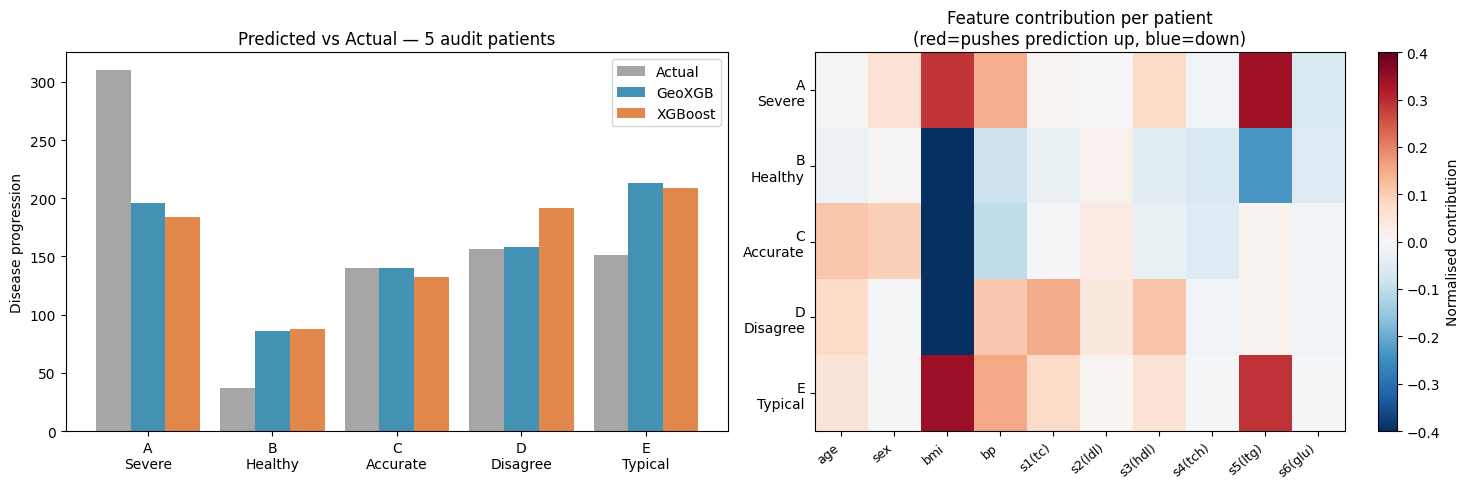

In [22]:
labels_short = ['A\nSevere', 'B\nHealthy', 'C\nAccurate', 'D\nDisagree', 'E\nTypical']
idxs  = list(audit_indices.values())
acts  = [float(y_test[i])         for i in idxs]
pgeos = [float(geo_preds_test[i]) for i in idxs]
pxgbs = [float(xgb_preds_test[i]) for i in idxs]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

x = np.arange(5); w = 0.28
ax = axes[0]
ax.bar(x - w,  acts,  w, label='Actual',  color='gray',    alpha=0.7)
ax.bar(x,      pgeos, w, label='GeoXGB',  color='#2e86ab', alpha=0.9)
ax.bar(x + w,  pxgbs, w, label='XGBoost', color='#e07b39', alpha=0.9)
ax.set_xticks(x); ax.set_xticklabels(labels_short)
ax.set_ylabel('Disease progression')
ax.set_title('Predicted vs Actual — 5 audit patients')
ax.legend()

# Feature contribution heatmap
contrib_matrix = np.zeros((5, len(feature_names)))
for row_i, test_idx in enumerate(idxs):
    X_s = X_test[test_idx]
    net = np.zeros(len(feature_names))
    for tree, lr in zip(geo_best._trees, geo_best._lr_values):
        delta     = lr * float(tree.predict(X_s.reshape(1, -1))[0])
        root_feat = tree.tree_.feature[0]
        if root_feat >= 0:
            net[root_feat] += delta
    contrib_matrix[row_i] = net / (np.abs(net).sum() + 1e-10)

ax = axes[1]
im = ax.imshow(contrib_matrix, cmap='RdBu_r', aspect='auto', vmin=-0.4, vmax=0.4)
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=40, ha='right', fontsize=9)
ax.set_yticks(range(5)); ax.set_yticklabels(labels_short)
ax.set_title('Feature contribution per patient\n(red=pushes prediction up, blue=down)')
fig.colorbar(im, ax=ax, label='Normalised contribution')
plt.tight_layout(); plt.show()


### What This Audit Demonstrates

**For a regulator**, GeoXGB provides three auditable layers that XGBoost cannot:

1. **Peer-group assignment** — every prediction is grounded in a partition of structurally similar training patients. The regulator can inspect who is in the peer group and whether the grouping is actuarially appropriate.

2. **Geometry-to-prediction traceability** — the HVRT partition tree is a simple decision tree in normalised feature space. Its rules are human-readable: `bmi > 0.031 AND s5(ltg) > 0.008 → Partition #3`. Directly inspectable without specialist ML knowledge.

3. **Layer divergence as a red flag** — when boosting importance and geometry importance disagree on a feature, the model is compensating geometrically. This surfaces potential blind spots that a single-layer model would hide.

**Patient D** (largest GeoXGB/XGBoost disagreement) is the most compelling regulatory case: both models saw the same features but produced different predictions. GeoXGB's answer comes with a peer-group context — you can see *which training patients influenced the prediction* and assess whether the grouping makes clinical or actuarial sense. XGBoost offers no equivalent traceability.